<a href="https://colab.research.google.com/github/BesT1CooKie1/pina_oedometer/blob/master/Kopie_von_02_nn_lstm_current_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template
## Load modules & Check PyTorch

In [ ]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import Markdown, display

import pandas as pd

# data processing
import random as r
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [ ]:
# Debugger: Aktiviert
debug_mode = True
normalize = True

## Preloaded Modules

In [ ]:
def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.

    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """

    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"

    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)


def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.

    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.

    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """

    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    total_epsilon = to_list(data_dict["total_epsilon"])
    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred)  # Falls `delta_sigma_pred` ein 2D-Array ist

    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(total_epsilon), len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "total_epsilon" : list(total_epsilon[:min_len]),
        "delta_epsilon" : list(delta_epsilon[:min_len]),
        "sigma_t" : list(sigma_t[:min_len]),
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }

    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

## Check for use of CONDA if available

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

No GPU available.


# Recurrent Neural Networks

Just as people do not have to think again each time about the things they have already learned, it is also possible to teach neural networks to recall knowledge they were being taught. This is done in so-called Recurrent Neural Networks (RNNs) with loops inside, which allow information to be retained. Currently the most used architectures of RNNs are Long short-term memory (LSTM) networks. LSTMs are RNNs that overcome the problem of long-term dependencies and thus have achieved the most state-of-the-art results in this area. In this exercise we will look at how to use LSTMs to predict future values using time series data sets.

## Data processing

In [ ]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005,
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]

        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])

        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen

    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])

    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

def plot_input():
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_dict_raw['sigma_t'], data_dict_raw['delta_sigma'], marker='o', linestyle='-', label='Sigma_0 = 1')

    # Formatting
    plt.xlabel('sigma_t')
    plt.ylabel('delta_simga')
    plt.title('Sigma_0 in relation to Sigma_1')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
i = 1000

oedo_para = {
    'max_n': 1,
    'e_0': 1.0,
    'C_c': 0.005,
    'total_epsilon': 0,
    'e_s': 400.0
}

# Vorbereitung Tensoren
sigma_t = np.random.choice(range(1, 10000), size=i, replace=False)
delta_sigma = []
delta_epsilon = np.repeat(np.array(np.float64(0.0005)), i)
# delta_epsilon = np.random.uniform(0.0001, 0.001, size=i)

for i in range(i):
    oedo_para['sigma_t'] = sigma_t[i]
    oedo_para['delta_epsilon'] = delta_epsilon[i]
    oedo = Oedometer(**oedo_para)
    delta_sigma.append(round(oedo.delta_sigma[0], 2))


print('Anzahl Elemente delta_epsilon: ' + str(len(delta_epsilon)))
print('Anzahl Elemente sigma_t: ' + str(len(sigma_t)))
print('Anzahl Elemente delta_sigma: ' + str(len(delta_sigma)))

Anzahl Elemente delta_epsilon: 1000
Anzahl Elemente sigma_t: 1000
Anzahl Elemente delta_sigma: 1000


In [54]:
data = [
    ['sigma_t'] + sigma_t.tolist(),
    ['delta_sigma'] + delta_sigma,
    ['delta_epsilon'] + delta_epsilon.tolist()
    ]

df = pd.DataFrame(data)
# Markdown Headlin 'RawData'
display(Markdown('### RawData'))
display(Markdown(df.to_markdown()))

### RawData

|    | 0             |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |       11 |        12 |        13 |       14 |        15 |        16 |        17 |        18 |        19 |        20 |        21 |        22 |        23 |        24 |        25 |        26 |        27 |        28 |        29 |       30 |        31 |        32 |        33 |        34 |        35 |        36 |        37 |        38 |        39 |        40 |        41 |        42 |        43 |        44 |        45 |        46 |        47 |        48 |        49 |        50 |        51 |        52 |        53 |        54 |       55 |        56 |        57 |        58 |        59 |        60 |        61 |        62 |        63 |        64 |       65 |       66 |        67 |        68 |       69 |        70 |        71 |        72 |        73 |        74 |        75 |        76 |        77 |        78 |        79 |        80 |        81 |       82 |        83 |        84 |        85 |        86 |        87 |        88 |        89 |      90 |        91 |        92 |        93 |       94 |        95 |        96 |       97 |        98 |        99 |       100 |       101 |       102 |       103 |       104 |       105 |      106 |      107 |       108 |       109 |       110 |       111 |       112 |       113 |     114 |       115 |       116 |       117 |       118 |       119 |       120 |       121 |       122 |       123 |       124 |       125 |       126 |       127 |       128 |       129 |       130 |       131 |       132 |       133 |       134 |       135 |       136 |       137 |       138 |      139 |       140 |       141 |       142 |       143 |       144 |       145 |       146 |       147 |       148 |       149 |       150 |       151 |       152 |       153 |       154 |       155 |       156 |       157 |       158 |      159 |       160 |       161 |       162 |       163 |       164 |       165 |       166 |       167 |       168 |       169 |       170 |      171 |       172 |       173 |       174 |      175 |       176 |       177 |       178 |       179 |       180 |       181 |       182 |       183 |       184 |       185 |      186 |      187 |       188 |       189 |       190 |       191 |       192 |       193 |       194 |       195 |       196 |       197 |       198 |       199 |       200 |       201 |       202 |       203 |       204 |       205 |     206 |       207 |       208 |       209 |       210 |       211 |       212 |       213 |       214 |       215 |       216 |       217 |       218 |       219 |       220 |       221 |       222 |       223 |       224 |       225 |       226 |       227 |       228 |       229 |       230 |       231 |       232 |       233 |       234 |       235 |       236 |       237 |      238 |      239 |       240 |       241 |       242 |       243 |       244 |       245 |       246 |       247 |      248 |      249 |       250 |       251 |       252 |       253 |       254 |       255 |       256 |       257 |       258 |       259 |       260 |       261 |       262 |       263 |       264 |       265 |       266 |       267 |       268 |     269 |       270 |       271 |      272 |       273 |       274 |       275 |       276 |       277 |       278 |       279 |       280 |       281 |       282 |       283 |       284 |       285 |       286 |       287 |       288 |       289 |       290 |       291 |       292 |       293 |       294 |       295 |       296 |       297 |      298 |     299 |       300 |       301 |       302 |       303 |      304 |      305 |       306 |     307 |       308 |       309 |       310 |       311 |       312 |       313 |       314 |       315 |       316 |       317 |      318 |       319 |       320 |       321 |       322 |       323 |       324 |       325 |       326 |       327 |       328 |       329 |       330 |       331 |       332 |       333 |       334 |      335 |       336 |    337 |       338 |       339 |       340 |       341 |       342 |       343 |      344 |       345 |       346 |       347 |       348 |       349 |       350 |       351 |       352 |       353 |      354 |       355 |       356 |       357 |       358 |       359 |       360 |       361 |       362 |       363 |       364 |       365 |       366 |       367 |       368 |       369 |      370 |       371 |       372 |       373 |       374 |       375 |       376 |       377 |       378 |       379 |      380 |       381 |       382 |       383 |       384 |       385 |       386 |       387 |       388 |       389 |       390 |       391 |      392 |       393 |       394 |       395 |       396 |       397 |       398 |       399 |       400 |       401 |       402 |       403 |       404 |       405 |       406 |      407 |       408 |       409 |       410 |       411 |       412 |       413 |       414 |       415 |       416 |       417 |       418 |       419 |       420 |      421 |       422 |       423 |       424 |       425 |       426 |       427 |       428 |       429 |       430 |       431 |      432 |      433 |       434 |       435 |       436 |       437 |       438 |      439 |       440 |       441 |       442 |       443 |       444 |       445 |       446 |       447 |       448 |       449 |      450 |       451 |       452 |       453 |      454 |       455 |       456 |       457 |       458 |      459 |       460 |       461 |      462 |       463 |       464 |       465 |       466 |       467 |       468 |      469 |       470 |      471 |       472 |      473 |       474 |       475 |       476 |       477 |      478 |       479 |       480 |       481 |       482 |       483 |       484 |       485 |       486 |       487 |       488 |       489 |      490 |       491 |       492 |       493 |       494 |       495 |       496 |       497 |       498 |       499 |       500 |       501 |       502 |       503 |       504 |       505 |       506 |       507 |       508 |       509 |      510 |       511 |      512 |       513 |       514 |       515 |       516 |       517 |       518 |       519 |       520 |       521 |       522 |      523 |       524 |       525 |       526 |       527 |       528 |       529 |       530 |       531 |       532 |       533 |       534 |       535 |       536 |       537 |       538 |       539 |       540 |       541 |       542 |       543 |       544 |       545 |       546 |       547 |       548 |       549 |       550 |       551 |       552 |       553 |       554 |       555 |       556 |      557 |       558 |       559 |       560 |       561 |       562 |       563 |       564 |       565 |       566 |       567 |       568 |       569 |      570 |       571 |       572 |       573 |       574 |       575 |      576 |       577 |       578 |       579 |       580 |       581 |       582 |       583 |       584 |       585 |       586 |       587 |       588 |      589 |       590 |       591 |       592 |       593 |       594 |       595 |       596 |       597 |       598 |       599 |      600 |       601 |       602 |       603 |       604 |       605 |       606 |       607 |       608 |       609 |       610 |      611 |       612 |       613 |       614 |       615 |       616 |       617 |       618 |       619 |       620 |      621 |       622 |       623 |      624 |       625 |       626 |       627 |       628 |       629 |       630 |       631 |       632 |      633 |       634 |       635 |       636 |       637 |       638 |       639 |      640 |       641 |       642 |      643 |       644 |       645 |       646 |       647 |       648 |       649 |       650 |       651 |       652 |       653 |       654 |      655 |       656 |       657 |       658 |      659 |       660 |       661 |       662 |       663 |     664 |       665 |      666 |       667 |       668 |       669 |      670 |       671 |       672 |       673 |       674 |       675 |       676 |      677 |      678 |       679 |       680 |       681 |       682 |       683 |       684 |       685 |       686 |       687 |       688 |       689 |       690 |       691 |       692 |       693 |       694 |       695 |       696 |       697 |       698 |       699 |       700 |       701 |       702 |       703 |       704 |       705 |       706 |       707 |       708 |       709 |       710 |       711 |       712 |       713 |       714 |       715 |       716 |       717 |       718 |       719 |       720 |       721 |       722 |       723 |       724 |       725 |      726 |       727 |       728 |       729 |       730 |       731 |       732 |       733 |       734 |       735 |       736 |       737 |       738 |       739 |      740 |       741 |       742 |       743 |       744 |       745 |       746 |      747 |       748 |      749 |       750 |       751 |       752 |       753 |       754 |       755 |       756 |       757 |       758 |       759 |       760 |       761 |       762 |       763 |       764 |       765 |       766 |       767 |       768 |       769 |       770 |       771 |       772 |       773 |      774 |       775 |       776 |       777 |       778 |       779 |       780 |       781 |       782 |       783 |       784 |     785 |       786 |       787 |       788 |       789 |       790 |       791 |      792 |       793 |       794 |       795 |       796 |       797 |       798 |       799 |       800 |       801 |       802 |       803 |       804 |       805 |       806 |       807 |      808 |       809 |       810 |      811 |       812 |       813 |       814 |       815 |       816 |       817 |       818 |       819 |       820 |       821 |       822 |       823 |       824 |       825 |       826 |       827 |       828 |       829 |       830 |       831 |       832 |       833 |       834 |       835 |       836 |       837 |       838 |      839 |      840 |      841 |       842 |       843 |       844 |       845 |      846 |       847 |       848 |       849 |       850 |       851 |       852 |       853 |       854 |       855 |       856 |       857 |       858 |       859 |       860 |       861 |       862 |       863 |       864 |       865 |      866 |       867 |       868 |       869 |      870 |       871 |       872 |       873 |       874 |       875 |       876 |       877 |       878 |       879 |       880 |       881 |       882 |       883 |       884 |       885 |       886 |       887 |       888 |       889 |       890 |     891 |       892 |       893 |       894 |       895 |       896 |       897 |       898 |       899 |       900 |      901 |       902 |       903 |       904 |       905 |       906 |       907 |       908 |       909 |       910 |       911 |       912 |       913 |       914 |       915 |       916 |       917 |       918 |       919 |       920 |       921 |      922 |       923 |       924 |       925 |       926 |       927 |       928 |       929 |       930 |       931 |       932 |       933 |      934 |       935 |       936 |       937 |       938 |       939 |       940 |       941 |       942 |      943 |       944 |       945 |      946 |       947 |       948 |       949 |       950 |      951 |       952 |       953 |       954 |       955 |       956 |       957 |       958 |       959 |      960 |       961 |       962 |       963 |       964 |       965 |       966 |       967 |       968 |       969 |       970 |       971 |       972 |       973 |     974 |       975 |       976 |       977 |       978 |       979 |       980 |      981 |       982 |       983 |       984 |       985 |       986 |       987 |       988 |      989 |    990 |       991 |       992 |       993 |       994 |       995 |       996 |       997 |       998 |       999 |      1000 |
|---:|:--------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|--------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|-------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|--------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|---------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|--------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|-------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
|  0 | sigma_t       | 9872      | 6769      | 7327      | 6161      | 8214      | 2847      | 8472      | 6361      | 1281      | 3681      | 200      | 7310      | 1630      | 323      | 7601      | 7541      | 9914      | 2923      | 3347      | 8874      | 3411      | 6967      | 7265      | 2955      | 3736      | 6881      | 4768      | 2751      | 8438      | 346      | 7654      | 2260      | 8046      | 3472      | 5876      | 4964      | 5452      | 7971      | 1861      | 7252      | 3724      | 2059      | 6694      | 1948      | 8727      | 9278      | 5335      | 8529      | 6547      | 4620      | 7232      | 7670      | 9999      | 9189      | 104      | 7402      | 6681      | 8366      | 3320      | 8832      | 6668      | 5345      | 4811      | 7864      | 601      | 325      | 8667      | 7260      | 512      | 1529      | 2162      | 5274      | 5132      | 4812      | 6793      | 6238      | 8783      | 6743      | 5700      | 3809      | 8549      | 602      | 6531      | 3700      | 3642      | 7460      | 9444      | 5131      | 6804      | 97      | 2350      | 8275      | 6755      | 922      | 3125      | 4992      | 972      | 2903      | 3774      | 1790      | 6867      | 2832      | 5562      | 8148      | 4290      | 551      | 536      | 1829      | 1259      | 5617      | 2645      | 3039      | 9950      | 59      | 7999      | 2701      | 5378      | 2022      | 1641      | 2917      | 8748      | 1976      | 9573      | 8731      | 9920      | 4693      | 9115      | 8789      | 5072      | 8303      | 5564      | 3037      | 3593      | 1066      | 1503      | 7397      | 3500      | 6437      | 432      | 9449      | 8264      | 5472      | 8080      | 7962      | 2061      | 5155      | 9190      | 8963      | 8654      | 5863      | 1144      | 3286      | 8018      | 7343      | 9984      | 2451      | 5978      | 4501      | 458      | 8597      | 3807      | 6592      | 3257      | 7131      | 3654      | 8987      | 2233      | 9932      | 4098      | 3778      | 712      | 5615      | 6125      | 7042      | 353      | 4337      | 2509      | 2562      | 8902      | 2889      | 4344      | 4225      | 6745      | 5679      | 9603      | 322      | 967      | 3854      | 6927      | 7544      | 1474      | 6299      | 8402      | 1466      | 5763      | 9843      | 8649      | 4574      | 6257      | 8547      | 4626      | 7542      | 6115      | 9609      | 7806      | 26      | 9056      | 2042      | 8169      | 7000      | 5520      | 8968      | 1022      | 1708      | 4312      | 2055      | 6167      | 4982      | 1324      | 7890      | 6796      | 2929      | 8151      | 3719      | 1760      | 3130      | 4859      | 2548      | 8555      | 3057      | 4133      | 5644      | 4751      | 3823      | 5167      | 2335      | 7573      | 558      | 722      | 5553      | 1145      | 9647      | 7234      | 2007      | 7642      | 9403      | 2487      | 565      | 804      | 6427      | 6333      | 1810      | 2008      | 5855      | 4977      | 4771      | 8322      | 2172      | 1329      | 7084      | 9237      | 5476      | 4490      | 4238      | 4151      | 1849      | 8775      | 2229      | 68      | 9220      | 6256      | 439      | 6070      | 1309      | 8533      | 3897      | 9216      | 3023      | 1745      | 1977      | 6222      | 5500      | 4093      | 1500      | 1375      | 7372      | 6187      | 7237      | 4296      | 7341      | 4529      | 7481      | 1012      | 8764      | 2697      | 2122      | 7184      | 664      | 94      | 4873      | 8202      | 7231      | 1430      | 498      | 748      | 1998      | 90      | 2463      | 5717      | 7243      | 7185      | 4549      | 6074      | 9422      | 8884      | 3004      | 4663      | 837      | 8645      | 8995      | 7039      | 9133      | 2881      | 6251      | 5684      | 9409      | 4493      | 3494      | 1363      | 8831      | 1988      | 1316      | 3981      | 5837      | 857      | 7172      | 1      | 9544      | 5100      | 4334      | 8186      | 8431      | 7267      | 781      | 6768      | 1485      | 5479      | 6126      | 3139      | 1936      | 8854      | 2886      | 5669      | 123      | 2974      | 4438      | 6689      | 2083      | 2097      | 3430      | 2062      | 4697      | 4643      | 7865      | 5305      | 2221      | 6713      | 3690      | 6925      | 151      | 1959      | 1739      | 2442      | 6489      | 4396      | 2041      | 6319      | 4119      | 3088      | 754      | 4105      | 3822      | 5945      | 8598      | 8864      | 3647      | 8559      | 2455      | 1405      | 4398      | 5199      | 278      | 9276      | 9319      | 8128      | 6300      | 9919      | 2207      | 5654      | 8607      | 6084      | 4215      | 5911      | 3862      | 8565      | 3674      | 288      | 7207      | 2490      | 2282      | 7752      | 8923      | 2668      | 4970      | 8621      | 7636      | 1876      | 8142      | 5634      | 2076      | 378      | 9358      | 9762      | 3110      | 7269      | 7333      | 7464      | 3490      | 9635      | 7480      | 4189      | 694      | 197      | 6814      | 1114      | 5618      | 6552      | 9734      | 447      | 7904      | 8550      | 4841      | 7708      | 3311      | 1076      | 5174      | 6176      | 5079      | 6249      | 128      | 7088      | 6347      | 4504      | 464      | 8951      | 8745      | 4262      | 7516      | 348      | 4049      | 6856      | 546      | 5883      | 2475      | 2181      | 9646      | 4016      | 7168      | 184      | 8469      | 494      | 5897      | 459      | 8701      | 2134      | 6401      | 4028      | 927      | 9653      | 7278      | 4275      | 8038      | 7861      | 6522      | 2461      | 7698      | 2093      | 7742      | 9410      | 108      | 9181      | 7287      | 5336      | 5065      | 8372      | 1443      | 8028      | 5884      | 6073      | 2570      | 5077      | 1199      | 2712      | 2349      | 3477      | 6517      | 8221      | 6710      | 1889      | 114      | 9576      | 863      | 5574      | 7786      | 4329      | 8235      | 5673      | 5148      | 4003      | 2327      | 4631      | 1269      | 874      | 5138      | 4557      | 6164      | 7679      | 3081      | 1228      | 4846      | 7872      | 5031      | 4394      | 6535      | 8876      | 8458      | 8279      | 3145      | 3723      | 3259      | 7824      | 8361      | 3995      | 7530      | 5010      | 2527      | 2444      | 6301      | 9990      | 9258      | 4817      | 4706      | 3046      | 5163      | 8124      | 8944      | 130      | 1839      | 7291      | 1712      | 7628      | 1236      | 7374      | 4887      | 3957      | 7330      | 7637      | 5235      | 2640      | 735      | 3657      | 1297      | 8232      | 7751      | 1093      | 733      | 2817      | 5777      | 7546      | 3707      | 9591      | 3432      | 8840      | 6785      | 3332      | 8015      | 6451      | 7626      | 708      | 2801      | 1809      | 2676      | 3441      | 4039      | 7554      | 7866      | 3049      | 8906      | 4921      | 820      | 6182      | 7467      | 6009      | 3498      | 9119      | 1416      | 3909      | 4526      | 6551      | 8242      | 302      | 3794      | 5244      | 7490      | 9266      | 3543      | 7748      | 6185      | 6789      | 1881      | 518      | 4821      | 3842      | 363      | 1071      | 6226      | 9514      | 1644      | 6863      | 9537      | 8892      | 6058      | 642      | 2469      | 6957      | 2541      | 2184      | 8475      | 4468      | 697      | 4351      | 9829      | 761      | 5441      | 2071      | 7368      | 8702      | 2009      | 6834      | 9028      | 9834      | 2015      | 8330      | 6008      | 770      | 1112      | 6440      | 8568      | 950      | 4420      | 3801      | 4084      | 4230      | 45      | 2121      | 125      | 1722      | 4730      | 4503      | 493      | 6954      | 1725      | 1423      | 2633      | 8065      | 1846      | 700      | 449      | 8534      | 3355      | 2814      | 5858      | 7123      | 7376      | 7307      | 1062      | 4158      | 5570      | 9526      | 9509      | 6937      | 8725      | 9023      | 3661      | 4325      | 2920      | 2931      | 3666      | 1450      | 3833      | 7104      | 8435      | 3232      | 3031      | 9789      | 3733      | 4560      | 4716      | 9342      | 2779      | 6315      | 8123      | 9443      | 1643      | 8244      | 7103      | 3541      | 7664      | 9598      | 2066      | 9248      | 3321      | 4893      | 1123      | 1268      | 810      | 4886      | 6160      | 6460      | 7762      | 1667      | 9571      | 2129      | 3343      | 1743      | 4877      | 4628      | 4916      | 9273      | 541      | 8895      | 9298      | 1663      | 9968      | 9059      | 6292      | 368      | 9185      | 981      | 7263      | 3198      | 7550      | 7650      | 1266      | 2151      | 5653      | 1160      | 3027      | 2020      | 6253      | 8819      | 7756      | 1937      | 6142      | 1924      | 9076      | 4234      | 1855      | 2850      | 1505      | 1326      | 2305      | 1095      | 992      | 5137      | 8912      | 9041      | 7715      | 6903      | 2148      | 2481      | 7508      | 5214      | 9709      | 70      | 2702      | 6316      | 5290      | 6643      | 7266      | 2168      | 443      | 4911      | 9801      | 9882      | 2108      | 8974      | 5096      | 5420      | 1543      | 2325      | 5854      | 2986      | 5291      | 9539      | 5063      | 9992      | 339      | 9363      | 7229      | 531      | 4938      | 5409      | 5774      | 4152      | 3618      | 6287      | 6113      | 9523      | 9578      | 6014      | 4037      | 7564      | 6964      | 1406      | 4048      | 7434      | 5393      | 6975      | 9870      | 8019      | 2804      | 3750      | 1134      | 5627      | 4380      | 6179      | 8162      | 205      | 652      | 481      | 9556      | 6122      | 7758      | 9957      | 734      | 2623      | 5209      | 8893      | 1235      | 9350      | 8308      | 5341      | 9029      | 5185      | 3626      | 9894      | 7770      | 4363      | 1969      | 1606      | 5754      | 1053      | 1168      | 3545      | 680      | 6931      | 7073      | 9301      | 705      | 9320      | 5248      | 5232      | 3464      | 4966      | 1912      | 6282      | 7832      | 4000      | 1021      | 9627      | 8512      | 2053      | 8394      | 1609      | 5180      | 9194      | 9654      | 1284      | 6864      | 23      | 6310      | 4046      | 7468      | 6138      | 7406      | 2116      | 5782      | 9895      | 2385      | 689      | 7379      | 9525      | 9642      | 4612      | 8378      | 3271      | 7551      | 7886      | 4986      | 3210      | 7033      | 9173      | 5492      | 7347      | 6818      | 9349      | 3899      | 1130      | 8428      | 2249      | 803      | 6041      | 4564      | 8790      | 9192      | 8127      | 9064      | 3588      | 6264      | 4844      | 2678      | 7170      | 757      | 7817      | 8967      | 5815      | 4007      | 1787      | 3030      | 9755      | 5203      | 851      | 3687      | 2046      | 262      | 4896      | 7413      | 6905      | 6771      | 749      | 3827      | 8192      | 7602      | 9630      | 9925      | 9131      | 5996      | 7256      | 235      | 6063      | 7609      | 9334      | 5501      | 9075      | 2879      | 5196      | 1129      | 7504      | 5820      | 9938      | 1247      | 1391      | 62      | 4813      | 8327      | 9241      | 5928      | 2331      | 7897      | 764      | 3804      | 8216      | 9947      | 8297      | 5154      | 5220      | 6136      | 903      | 2      | 8215      | 4520      | 3428      | 1878      | 1472      | 3584      | 9650      | 5170      | 6868      | 4862      |
|  1 | delta_sigma   | 1974.4    | 1353.8    | 1465.4    | 1232.2    | 1642.8    |  569.4    | 1694.4    | 1272.2    |  256.2    |  736.2    |  40      | 1462      |  326      |  64.6    | 1520.2    | 1508.2    | 1982.8    |  584.6    |  669.4    | 1774.8    |  682.2    | 1393.4    | 1453      |  591      |  747.2    | 1376.2    |  953.6    |  550.2    | 1687.6    |  69.2    | 1530.8    |  452      | 1609.2    |  694.4    | 1175.2    |  992.8    | 1090.4    | 1594.2    |  372.2    | 1450.4    |  744.8    |  411.8    | 1338.8    |  389.6    | 1745.4    | 1855.6    | 1067      | 1705.8    | 1309.4    |  924      | 1446.4    | 1534      | 1999.8    | 1837.8    |  20.8    | 1480.4    | 1336.2    | 1673.2    |  664      | 1766.4    | 1333.6    | 1069      |  962.2    | 1572.8    | 120.2    |  65      | 1733.4    | 1452      | 102.4    |  305.8    |  432.4    | 1054.8    | 1026.4    |  962.4    | 1358.6    | 1247.6    | 1756.6    | 1348.6    | 1140      |  761.8    | 1709.8    | 120.4    | 1306.2    |  740      |  728.4    | 1492      | 1888.8    | 1026.2    | 1360.8    | 19.4    |  470      | 1655      | 1351      | 184.4    |  625      |  998.4    | 194.4    |  580.6    |  754.8    |  358      | 1373.4    |  566.4    | 1112.4    | 1629.6    |  858      | 110.2    | 107.2    |  365.8    |  251.8    | 1123.4    |  529      |  607.8    | 1990      | 11.8    | 1599.8    |  540.2    | 1075.6    |  404.4    |  328.2    |  583.4    | 1749.6    |  395.2    | 1914.6    | 1746.2    | 1984      |  938.6    | 1823      | 1757.8    | 1014.4    | 1660.6    | 1112.8    |  607.4    |  718.6    |  213.2    |  300.6    | 1479.4    |  700      | 1287.4    |  86.4    | 1889.8    | 1652.8    | 1094.4    | 1616      | 1592.4    |  412.2    | 1031      | 1838      | 1792.6    | 1730.8    | 1172.6    |  228.8    |  657.2    | 1603.6    | 1468.6    | 1996.8    |  490.2    | 1195.6    |  900.2    |  91.6    | 1719.4    |  761.4    | 1318.4    |  651.4    | 1426.2    |  730.8    | 1797.4    |  446.6    | 1986.4    |  819.6    |  755.6    | 142.4    | 1123      | 1225      | 1408.4    |  70.6    |  867.4    |  501.8    |  512.4    | 1780.4    |  577.8    |  868.8    |  845      | 1349      | 1135.8    | 1920.6    |  64.4    | 193.4    |  770.8    | 1385.4    | 1508.8    |  294.8    | 1259.8    | 1680.4    |  293.2    | 1152.6    | 1968.6    | 1729.8    |  914.8    | 1251.4    | 1709.4    |  925.2    | 1508.4    | 1223      | 1921.8    | 1561.2    |  5.2    | 1811.2    |  408.4    | 1633.8    | 1400      | 1104      | 1793.6    |  204.4    |  341.6    |  862.4    |  411      | 1233.4    |  996.4    |  264.8    | 1578      | 1359.2    |  585.8    | 1630.2    |  743.8    |  352      |  626      |  971.8    |  509.6    | 1711      |  611.4    |  826.6    | 1128.8    |  950.2    |  764.6    | 1033.4    |  467      | 1514.6    | 111.6    | 144.4    | 1110.6    |  229      | 1929.4    | 1446.8    |  401.4    | 1528.4    | 1880.6    |  497.4    | 113      | 160.8    | 1285.4    | 1266.6    |  362      |  401.6    | 1171      |  995.4    |  954.2    | 1664.4    |  434.4    |  265.8    | 1416.8    | 1847.4    | 1095.2    |  898      |  847.6    |  830.2    |  369.8    | 1755      |  445.8    | 13.6    | 1844      | 1251.2    |  87.8    | 1214      |  261.8    | 1706.6    |  779.4    | 1843.2    |  604.6    |  349      |  395.4    | 1244.4    | 1100      |  818.6    |  300      |  275      | 1474.4    | 1237.4    | 1447.4    |  859.2    | 1468.2    |  905.8    | 1496.2    |  202.4    | 1752.8    |  539.4    |  424.4    | 1436.8    | 132.8    | 18.8    |  974.6    | 1640.4    | 1446.2    |  286      |  99.6    | 149.6    |  399.6    | 18      |  492.6    | 1143.4    | 1448.6    | 1437      |  909.8    | 1214.8    | 1884.4    | 1776.8    |  600.8    |  932.6    | 167.4    | 1729      | 1799      | 1407.8    | 1826.6    |  576.2    | 1250.2    | 1136.8    | 1881.8    |  898.6    |  698.8    |  272.6    | 1766.2    |  397.6    |  263.2    |  796.2    | 1167.4    | 171.4    | 1434.4    | 0.2    | 1908.8    | 1020      |  866.8    | 1637.2    | 1686.2    | 1453.4    | 156.2    | 1353.6    |  297      | 1095.8    | 1225.2    |  627.8    |  387.2    | 1770.8    |  577.2    | 1133.8    |  24.6    |  594.8    |  887.6    | 1337.8    |  416.6    |  419.4    |  686      |  412.4    |  939.4    |  928.6    | 1573      | 1061      |  444.2    | 1342.6    |  738      | 1385      |  30.2    |  391.8    |  347.8    |  488.4    | 1297.8    |  879.2    |  408.2    | 1263.8    |  823.8    |  617.6    | 150.8    |  821      |  764.4    | 1189      | 1719.6    | 1772.8    |  729.4    | 1711.8    |  491      |  281      |  879.6    | 1039.8    |  55.6    | 1855.2    | 1863.8    | 1625.6    | 1260      | 1983.8    |  441.4    | 1130.8    | 1721.4    | 1216.8    |  843      | 1182.2    |  772.4    | 1713      |  734.8    |  57.6    | 1441.4    |  498      |  456.4    | 1550.4    | 1784.6    |  533.6    |  994      | 1724.2    | 1527.2    |  375.2    | 1628.4    | 1126.8    |  415.2    |  75.6    | 1871.6    | 1952.4    |  622      | 1453.8    | 1466.6    | 1492.8    |  698      | 1927      | 1496      |  837.8    | 138.8    |  39.4    | 1362.8    |  222.8    | 1123.6    | 1310.4    | 1946.8    |  89.4    | 1580.8    | 1710      |  968.2    | 1541.6    |  662.2    |  215.2    | 1034.8    | 1235.2    | 1015.8    | 1249.8    |  25.6    | 1417.6    | 1269.4    |  900.8    |  92.8    | 1790.2    | 1749      |  852.4    | 1503.2    |  69.6    |  809.8    | 1371.2    | 109.2    | 1176.6    |  495      |  436.2    | 1929.2    |  803.2    | 1433.6    |  36.8    | 1693.8    |  98.8    | 1179.4    |  91.8    | 1740.2    |  426.8    | 1280.2    |  805.6    | 185.4    | 1930.6    | 1455.6    |  855      | 1607.6    | 1572.2    | 1304.4    |  492.2    | 1539.6    |  418.6    | 1548.4    | 1882      |  21.6    | 1836.2    | 1457.4    | 1067.2    | 1013      | 1674.4    |  288.6    | 1605.6    | 1176.8    | 1214.6    |  514      | 1015.4    |  239.8    |  542.4    |  469.8    |  695.4    | 1303.4    | 1644.2    | 1342      |  377.8    |  22.8    | 1915.2    | 172.6    | 1114.8    | 1557.2    |  865.8    | 1647      | 1134.6    | 1029.6    |  800.6    |  465.4    |  926.2    |  253.8    | 174.8    | 1027.6    |  911.4    | 1232.8    | 1535.8    |  616.2    |  245.6    |  969.2    | 1574.4    | 1006.2    |  878.8    | 1307      | 1775.2    | 1691.6    | 1655.8    |  629      |  744.6    |  651.8    | 1564.8    | 1672.2    |  799      | 1506      | 1002      |  505.4    |  488.8    | 1260.2    | 1998      | 1851.6    |  963.4    |  941.2    |  609.2    | 1032.6    | 1624.8    | 1788.8    |  26      |  367.8    | 1458.2    |  342.4    | 1525.6    |  247.2    | 1474.8    |  977.4    |  791.4    | 1466      | 1527.4    | 1047      |  528      | 147      |  731.4    |  259.4    | 1646.4    | 1550.2    |  218.6    | 146.6    |  563.4    | 1155.4    | 1509.2    |  741.4    | 1918.2    |  686.4    | 1768      | 1357      |  666.4    | 1603      | 1290.2    | 1525.2    | 141.6    |  560.2    |  361.8    |  535.2    |  688.2    |  807.8    | 1510.8    | 1573.2    |  609.8    | 1781.2    |  984.2    | 164      | 1236.4    | 1493.4    | 1201.8    |  699.6    | 1823.8    |  283.2    |  781.8    |  905.2    | 1310.2    | 1648.4    |  60.4    |  758.8    | 1048.8    | 1498      | 1853.2    |  708.6    | 1549.6    | 1237      | 1357.8    |  376.2    | 103.6    |  964.2    |  768.4    |  72.6    |  214.2    | 1245.2    | 1902.8    |  328.8    | 1372.6    | 1907.4    | 1778.4    | 1211.6    | 128.4    |  493.8    | 1391.4    |  508.2    |  436.8    | 1695      |  893.6    | 139.4    |  870.2    | 1965.8    | 152.2    | 1088.2    |  414.2    | 1473.6    | 1740.4    |  401.8    | 1366.8    | 1805.6    | 1966.8    |  403      | 1666      | 1201.6    | 154      |  222.4    | 1288      | 1713.6    | 190      |  884      |  760.2    |  816.8    |  846      |  9      |  424.2    |  25      |  344.4    |  946      |  900.6    |  98.6    | 1390.8    |  345      |  284.6    |  526.6    | 1613      |  369.2    | 140      |  89.8    | 1706.8    |  671      |  562.8    | 1171.6    | 1424.6    | 1475.2    | 1461.4    |  212.4    |  831.6    | 1114      | 1905.2    | 1901.8    | 1387.4    | 1745      | 1804.6    |  732.2    |  865      |  584      |  586.2    |  733.2    |  290      |  766.6    | 1420.8    | 1687      |  646.4    |  606.2    | 1957.8    |  746.6    |  912      |  943.2    | 1868.4    |  555.8    | 1263      | 1624.6    | 1888.6    |  328.6    | 1648.8    | 1420.6    |  708.2    | 1532.8    | 1919.6    |  413.2    | 1849.6    |  664.2    |  978.6    |  224.6    |  253.6    | 162      |  977.2    | 1232      | 1292      | 1552.4    |  333.4    | 1914.2    |  425.8    |  668.6    |  348.6    |  975.4    |  925.6    |  983.2    | 1854.6    | 108.2    | 1779      | 1859.6    |  332.6    | 1993.6    | 1811.8    | 1258.4    |  73.6    | 1837      | 196.2    | 1452.6    |  639.6    | 1510      | 1530      |  253.2    |  430.2    | 1130.6    |  232      |  605.4    |  404      | 1250.6    | 1763.8    | 1551.2    |  387.4    | 1228.4    |  384.8    | 1815.2    |  846.8    |  371      |  570      |  301      |  265.2    |  461      |  219      | 198.4    | 1027.4    | 1782.4    | 1808.2    | 1543      | 1380.6    |  429.6    |  496.2    | 1501.6    | 1042.8    | 1941.8    | 14      |  540.4    | 1263.2    | 1058      | 1328.6    | 1453.2    |  433.6    |  88.6    |  982.2    | 1960.2    | 1976.4    |  421.6    | 1794.8    | 1019.2    | 1084      |  308.6    |  465      | 1170.8    |  597.2    | 1058.2    | 1907.8    | 1012.6    | 1998.4    |  67.8    | 1872.6    | 1445.8    | 106.2    |  987.6    | 1081.8    | 1154.8    |  830.4    |  723.6    | 1257.4    | 1222.6    | 1904.6    | 1915.6    | 1202.8    |  807.4    | 1512.8    | 1392.8    |  281.2    |  809.6    | 1486.8    | 1078.6    | 1395      | 1974      | 1603.8    |  560.8    |  750      |  226.8    | 1125.4    |  876      | 1235.8    | 1632.4    |  41      | 130.4    |  96.2    | 1911.2    | 1224.4    | 1551.6    | 1991.4    | 146.8    |  524.6    | 1041.8    | 1778.6    |  247      | 1870      | 1661.6    | 1068.2    | 1805.8    | 1037      |  725.2    | 1978.8    | 1554      |  872.6    |  393.8    |  321.2    | 1150.8    |  210.6    |  233.6    |  709      | 136      | 1386.2    | 1414.6    | 1860.2    | 141      | 1864      | 1049.6    | 1046.4    |  692.8    |  993.2    |  382.4    | 1256.4    | 1566.4    |  800      |  204.2    | 1925.4    | 1702.4    |  410.6    | 1678.8    |  321.8    | 1036      | 1838.8    | 1930.8    |  256.8    | 1372.8    |  4.6    | 1262      |  809.2    | 1493.6    | 1227.6    | 1481.2    |  423.2    | 1156.4    | 1979      |  477      | 137.8    | 1475.8    | 1905      | 1928.4    |  922.4    | 1675.6    |  654.2    | 1510.2    | 1577.2    |  997.2    |  642      | 1406.6    | 1834.6    | 1098.4    | 1469.4    | 1363.6    | 1869.8    |  779.8    |  226      | 1685.6    |  449.8    | 160.6    | 1208.2    |  912.8    | 1758      | 1838.4    | 1625.4    | 1812.8    |  717.6    | 1252.8    |  968.8    |  535.6    | 1434      | 151.4    | 1563.4    | 1793.4    | 1163      |  801.4    |  357.4    |  606      | 1951      | 1040.6    | 170.2    |  737.4    |  409.2    |  52.4    |  979.2    | 1482.6    | 1381      | 1354.2    | 149.8    |  765.4    | 1638.4    | 1520.4    | 1926      | 1985      | 1826.2    | 1199.2    | 1451.2    |  47      | 1212.6    | 1521.8    | 1866.8    | 1100.2    | 1815      |  575.8    | 1039.2    |  225.8    | 1500.8    | 1164      | 1987.6    |  249.4    |  278.2    | 12.4    |  962.6    | 1665.4    | 1848.2    | 1185.6    |  466.2    | 1579.4    | 152.8    |  760.8    | 1643.2    | 1989.4    | 1659.4    | 1030.8    | 1044      | 1227.2    | 180.6    | 0.4    | 1643      |  904      |  685.6    |  375.6    |  294.4    |  716.8    | 1930      | 1034      | 1373.6    |  972.4    |
|  2 | delta_epsilon |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 | 0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |   0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |  0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |   0.0005 | 0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |    0.0005 |

In [ ]:
min_val = None
max_val = None

def min_max_normalize(tensor):
    global min_val, max_val
    if min_val is None or max_val is None:
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
    else:
        pass
    display(Markdown(f'### Skalierungseinheiten: Min. = {min_val}, Max. = {max_val}'))
    return (tensor - min_val) / (max_val - min_val)

def min_max_denormalize(tensor):
  """
  Denormalisiert einen Tensor anhand der globalen min_val und max_val.
  """
  if min_val is None or max_val is None:
    print("Fehler: min_val und/oder max_val sind nicht gesetzt. Normalisierung muss zuerst durchgeführt werden.")
    return tensor # Gibt den ursprünglichen Tensor zurück, wenn nicht normalisiert werden kann
  return tensor * (max_val - min_val) + min_val


### Warum nur der Input skaliert wird

In der Regel wird nur der **Input** normalisiert, weil der **Output** oft als das Ziel betrachtet wird, das das Modell vorhersagen soll. Das Ziel soll in der gleichen Skala und den gleichen Einheiten bleiben, um eine einfache Interpretation und Rücktransformation der Vorhersagen zu ermöglichen. Wenn der Output normalisiert wird, muss er nach der Vorhersage wieder denormalisiert werden, was zusätzliche Komplexität verursacht.

Die Eingabedaten haben häufig eine sehr unterschiedliche Skala, und die Normalisierung stellt sicher, dass alle Eingabefeatures im gleichen Bereich liegen, was das Training des Modells stabiler und effizienter macht.

> **StackOverflow:**
> - [Stack Overflow Neural Networks normalizing output data](https://stackoverflow.com/questions/42604261/neural-networks-normalizing-output-data)

In [ ]:
def create_dataset(df, lookback=1, input_columns=None, output_columns=None, normalize=True):
    """
    Erzeugt die Eingabe- und Ziel-Datensätze für ein LSTM.

    Parameters:
    df (DataFrame): Der Eingabedatenrahmen.
    lookback (int): Die Anzahl der vergangenen Zeitschritte, die als Eingabe dienen.
    input_columns (list): Liste der Spaltennamen, die als Eingabewerte dienen.
    output_columns (list): Liste der Spaltennamen, die als Zielwerte dienen.
    normalize (bool): Ob die Eingabedaten normalisiert werden sollen.

    Returns:
    X (Tensor): Eingabedaten im Format (batch_size, seq_length, input_size).
    y (Tensor): Zielwerte im Format (batch_size, output_size).
    """
    X, y = [], []

    # Falls keine input_columns übergeben wurden, nehmen wir alle Spalten außer der letzten
    if input_columns is None:
        input_columns = df.columns[:-1].tolist()

    # Falls keine output_columns übergeben wurden, nehmen wir die letzte(n) Spalte(n)
    if output_columns is None:
        output_columns = df.columns[-1:].tolist()  # Eine Liste mit der letzten Spalte

    for i in range(len(df) - lookback):
        # Wir nehmen 'lookback' Zeilen als eine Sequenz für die Eingabe
        seq = df.iloc[i:i+lookback][input_columns].values
        X.append(seq)

        # Zielwert(e) ist (sind) der Wert(e) der output_columns nach dieser Sequenz
        y_values = df.iloc[i+lookback][output_columns].values
        y.append(y_values)

    # Umwandlung in Tensoren
    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32)

    # Falls Normalisierung gewünscht ist, wenden wir min-max Normalisierung an
    if normalize:
        X_tensor = min_max_normalize(X_tensor)

    return X_tensor, y_tensor

X, y = create_dataset(df, lookback=1, normalize=normalize, input_columns=['sigma_t', 'delta_epsilon'], output_columns=['delta_sigma'])

### Skalierungseinheiten: Min. = 0.0005000000237487257, Max. = 9999.0

In [ ]:
# --- Aufteilen in Training (2/3) und Test (1/3) ---
train_size = int(X.shape[0] * 2/3)
X_train = X[:train_size]
y_train = y[:train_size].view(-1, 1)  # als (batch_size, 1)
X_test  = X[train_size:]
y_test  = y[train_size:].view(-1, 1)

print("Shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_test: ", X_test.shape,  "y_test: ", y_test.shape)

Shapes:
  X_train: torch.Size([666, 1, 2]) y_train: torch.Size([666, 1])
  X_test:  torch.Size([333, 1, 2]) y_test:  torch.Size([333, 1])


### Warum der erste Output-Wert im Trainingsdatensatz "fehlt"

Bei der Vorbereitung von Zeitreihendaten für ein Long Short-Term Memory (LSTM) Modell, insbesondere wenn ein `lookback`-Wert größer als Null verwendet wird, gibt es eine wichtige Besonderheit bezüglich des ersten Elements im Ziel-Datensatz (`y`).

**Die Logik von `create_dataset`:**

Unsere `create_dataset` Funktion erstellt Paare von Input-Sequenzen (`X`) und den entsprechenden zukünftigen Zielwerten (`y`). Bei einem `lookback` von $N$:

*   Der **Input** für das $i$-te Trainingsbeispiel (`X[i]`) besteht aus den Daten der letzten $N$ Zeitschritte (von Index $i$ bis $i + N - 1$ im ursprünglichen DataFrame).
*   Der **Output** für das $i$-te Trainingsbeispiel (`y[i]`) ist der Wert des darauf folgenden Zeitschritts (am Index $i + N$ im ursprünglichen DataFrame).

**Der Effekt des `lookback`:**

Betrachten wir den Fall mit `lookback = 1` (wie in unserem Notebook):

*   Das erste Trainingsbeispiel (`i=0`) hat als Input die Daten von Index 0 im Original-DataFrame und als Output die Daten von Index 1.
*   Das zweite Trainingsbeispiel (`i=1`) hat als Input die Daten von Index 1 im Original-DataFrame und als Output die Daten von Index 2.
*   Und so weiter, bis zum letzten möglichen Paar.

**Warum der erste Wert im Originaldatensatz übersprungen wird:**

Der allererste Wert im ursprünglichen DataFrame (am Index 0) kann nicht als Zielwert (`y`) für das erste Trainingsbeispiel verwendet werden, weil es keine vorherigen Daten gibt (bei einem `lookback > 0`), die als Input-Sequenz dienen könnten, um diesen Wert vorherzusagen.

**Zusammenfassend:**

Wenn `lookback > 0` ist, werden die ersten `lookback` Elemente des ursprünglichen DataFrames nicht als Zielwerte (`y`) in den vom `create_dataset` erzeugten Tensoren erscheinen. Dies ist kein Fehler, sondern eine notwendige Konsequenz der Vorbereitung von Zeitreihendaten für ein sequenzbasiertes Modell wie ein LSTM, das eine Vergangenheit benötigt, um die Zukunft vorherzusagen.

Die Tabellen zur Denormalisierungsüberprüfung zeigen diese Logik durch die Spalten "Input Rohdaten Index" und "Output Rohdaten Index", die die genaue Position der Daten im ursprünglichen Datensatz referenzieren.

In [ ]:
num_rows = 10  # Anzahl der Zeilen, die in den Tabellen angezeigt werden sollen
lookback = 1 # Stelle sicher, dass dies deinem tatsächlichen lookback-Wert entspricht

# Trainingsdaten anzeigen (Normalisiert) - Hier passen Input und Output zusammen, wie vom create_dataset erstellt
display(dict_to_markdown_table({
    'Input (sigma_t, delta_epsilon)': [X_train[i].squeeze().tolist() for i in range(min(num_rows, X_train.shape[0]))],
    'Output (delta_sigma)': y_train[:min(num_rows, y_train.shape[0])].squeeze().tolist()
}, title="Trainingsdaten (Normalisierte Input Parameter)", include_index=True))

# Trainingsdaten denormalisiert anzeigen
X_train_denormalized = min_max_denormalize(X_train)
y_train_denormalized = y_train

# Rohdaten für den Vergleich extrahieren (entspricht den Trainingsdaten)
# Die Trainingsdaten sind die ersten 'train_size' Samples der Input-Output-Paare.
# Wir müssen die entsprechenden originalen Werte aus dem 'data' Dictionary holen.

# Die Inputs X_train[i] stammen aus den Originaldaten bei Index i.
original_sigma_t_input = data['sigma_t'][:train_size]
original_delta_epsilon_input = data['delta_epsilon'][:train_size]

# Die Outputs y_train[i] stammen aus den Originaldaten bei Index i + lookback.
original_delta_sigma_output = data['delta_sigma'][lookback : train_size + lookback]


# Listen für die detaillierte denormalisierte Tabelle
denormalized_inputs_list = []
denormalized_outputs_list = []
input_original_indices = [] # Um die Rohdaten-Indizes für Inputs zu speichern
output_original_indices = [] # Um die Rohdaten-Indizes für Outputs zu speichern
input_verification_diff = []
output_verification_diff = []

for i in range(min(num_rows, X_train_denormalized.shape[0])):
    # Denormalisierte Werte
    denorm_sigma_t = X_train_denormalized[i].squeeze()[0].item()
    denorm_delta_epsilon = X_train_denormalized[i].squeeze()[1].item()
    denorm_delta_sigma_output = y_train_denormalized[i].squeeze().item()

    denormalized_inputs_list.append([denorm_sigma_t, denorm_delta_epsilon])
    denormalized_outputs_list.append(denorm_delta_sigma_output)

    # Rohdaten-Index für den Input: i
    input_index = i
    input_original_indices.append(input_index)
    original_sigma_t = data['sigma_t'][input_index]
    original_delta_epsilon = data['delta_epsilon'][input_index]
    diff_sigma_t = denorm_sigma_t - original_sigma_t
    diff_delta_epsilon = denorm_delta_epsilon - original_delta_epsilon
    input_verification_diff.append(f"sigma_t Diff: {diff_sigma_t:.4f}, delta_epsilon Diff: {diff_delta_epsilon:.6f}")


    # Rohdaten-Index für den Output: i + lookback
    output_index = i + lookback
    output_original_indices.append(output_index)
    original_delta_sigma = data['delta_sigma'][output_index]
    diff_delta_sigma = denorm_delta_sigma_output - original_delta_sigma
    output_verification_diff.append(f"delta_sigma Diff: {diff_delta_sigma:.4f}")


# Anzeige der denormalisierten Trainingsdaten mit Input-Verifizierung
# Wir fügen die Rohdaten-Indizes für Input und Output zur besseren Übersicht hinzu.
display(dict_to_markdown_table({
    'Input Rohdaten Index': input_original_indices,
    'Input (sigma_t, delta_epsilon)': denormalized_inputs_list,
    'Denormalisierung Input Check (Diff zu Original)': input_verification_diff,
    'Output Rohdaten Index': output_original_indices,
    'Output (delta_sigma)': denormalized_outputs_list,
    'Denormalisierung Output Check (Diff zu Original)': output_verification_diff
    }, title="Trainingsdaten (Denormalisiert) mit Checks", include_index=True))

### Trainingsdaten (Normalisierte Input Parameter)

| Index | Input (sigma_t, delta_epsilon) | Output (delta_sigma) |
|--|-------------------------------|---------------------|
| 0 | [0.9872987270355225, 0.0] | 1353.8 |
| 1 | [0.6769677400588989, 0.0] | 1465.4 |
| 2 | [0.7327733039855957, 0.0] | 1232.2 |
| 3 | [0.6161616444587708, 0.0] | 1642.8 |
| 4 | [0.8214821219444275, 0.0] | 569.4 |
| 5 | [0.28472843766212463, 0.0] | 1694.4 |
| 6 | [0.847284734249115, 0.0] | 1272.2 |
| 7 | [0.6361636519432068, 0.0] | 256.2 |
| 8 | [0.1281127780675888, 0.0] | 736.2 |
| 9 | [0.36813679337501526, 0.0] | 40.0 |


### Trainingsdaten (Denormalisiert) mit Checks

| Index | Input Rohdaten Index | Input (sigma_t, delta_epsilon) | Denormalisierung Input Check (Diff zu Original) | Output Rohdaten Index | Output (delta_sigma) | Denormalisierung Output Check (Diff zu Original) |
|--|---------------------|-------------------------------|------------------------------------------------|----------------------|---------------------|-------------------------------------------------|
| 0 | 0 | [9872.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 1 | 1353.8 | delta_sigma Diff: 0.0000 |
| 1 | 1 | [6769.00048828125, 0.0005000000237487257] | sigma_t Diff: 0.0005, delta_epsilon Diff: 0.000000 | 2 | 1465.4 | delta_sigma Diff: 0.0000 |
| 2 | 2 | [7327.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 3 | 1232.2 | delta_sigma Diff: -0.0000 |
| 3 | 3 | [6161.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 4 | 1642.8 | delta_sigma Diff: 0.0000 |
| 4 | 4 | [8214.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 5 | 569.4 | delta_sigma Diff: 0.0000 |
| 5 | 5 | [2846.999755859375, 0.0005000000237487257] | sigma_t Diff: -0.0002, delta_epsilon Diff: 0.000000 | 6 | 1694.4 | delta_sigma Diff: 0.0000 |
| 6 | 6 | [8472.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 7 | 1272.2 | delta_sigma Diff: -0.0000 |
| 7 | 7 | [6361.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 8 | 256.2 | delta_sigma Diff: 0.0000 |
| 8 | 8 | [1281.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 9 | 736.2 | delta_sigma Diff: 0.0000 |
| 9 | 9 | [3681.0, 0.0005000000237487257] | sigma_t Diff: 0.0000, delta_epsilon Diff: 0.000000 | 10 | 40.0 | delta_sigma Diff: 0.0000 |


In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [ ]:
# Hyperparameter
input_size = X_train.shape[2]  # Anzahl der Input-Features
hidden_size = 32  # Die Anzahl der Neuronen im LSTM
num_layers = 3  # Anzahl der LSTM-Schichten
output_size = 1  # Output ist eine einzelne Zahl (z. B. Vorhersage)

# Modell, Loss und Optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Frühzeitige Beendigung: Überwache den Verlust auf den Validierungsdaten
best_val_loss = float('inf')  # Initialer hoher Verlust
patience = 20  # Anzahl der Epochen ohne Verbesserung, bevor das Training gestoppt wird
patience_counter = 0  # Zähler für die Anzahl der Epochen ohne Verbesserung

# Liste zum Speichern der Loss-Werte
losses = []

# Batches erstellen
batch_size = 16

# Erstelle TensorDataset und DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_test, y_test)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Improvement Block Aktivierung (True/False)
improvement_block = True

# Training
epochs = 10000
for epoch in range(epochs):
    model.train()  # Setze das Modell in den Trainingsmodus
    running_loss = 0.0

    # Schleife über Batches
    for i, (x_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Modellvorhersage
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)  # Verlust auf den Trainingsdaten
        loss.backward()
        optimizer.step()

        # Verlust sammeln
        running_loss += loss.item()

    # Durchschnittlichen Trainingsverlust berechnen
    avg_train_loss = running_loss / len(train_dataloader)
    losses.append(avg_train_loss)

    # Frühzeitige Beendigung (improvement block) aktivieren
    if improvement_block:
        # Validierungsverlust berechnen
        model.eval()  # Modell in den Evaluierungsmodus setzen
        val_loss = 0.0
        with torch.no_grad():
            for x_batch_val, y_batch_val in val_dataloader:
                val_outputs = model(x_batch_val)
                loss = criterion(val_outputs, y_batch_val)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)

        # Frühzeitige Beendigung überwachen
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset der Geduld
        else:
            patience_counter += 1

        # Wenn keine Verbesserung erfolgt, abbrechen
        if patience_counter >= patience:
            print(f"Frühzeitige Beendigung nach {epoch + 1} Epochen wegen fehlender Verbesserung.")
            break

        # Ausgabe der Verlustinformationen
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    else:
        # Ausgabe der Verlustinformationen ohne Validierung
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}')

Epoch 10/10000, Train Loss: 1289020.594216, Validation Loss: 1419536.036765
Epoch 20/10000, Train Loss: 1265191.672575, Validation Loss: 1396120.233456
Epoch 30/10000, Train Loss: 1244241.452892, Validation Loss: 1374034.312500
Epoch 40/10000, Train Loss: 1225146.958022, Validation Loss: 1352593.349265
Epoch 50/10000, Train Loss: 1208526.777985, Validation Loss: 1331519.211397
Epoch 60/10000, Train Loss: 1187348.703825, Validation Loss: 1310695.435662
Epoch 70/10000, Train Loss: 1162685.038713, Validation Loss: 1290198.332721
Epoch 80/10000, Train Loss: 1151846.298507, Validation Loss: 1269954.003676
Epoch 90/10000, Train Loss: 1124742.147854, Validation Loss: 1249972.472426
Epoch 100/10000, Train Loss: 1109234.723881, Validation Loss: 1230218.295956
Epoch 110/10000, Train Loss: 1093108.541278, Validation Loss: 1210680.696691
Epoch 120/10000, Train Loss: 1071334.908582, Validation Loss: 1191365.715074
Epoch 130/10000, Train Loss: 1056980.050840, Validation Loss: 1172328.428309
Epoch 14

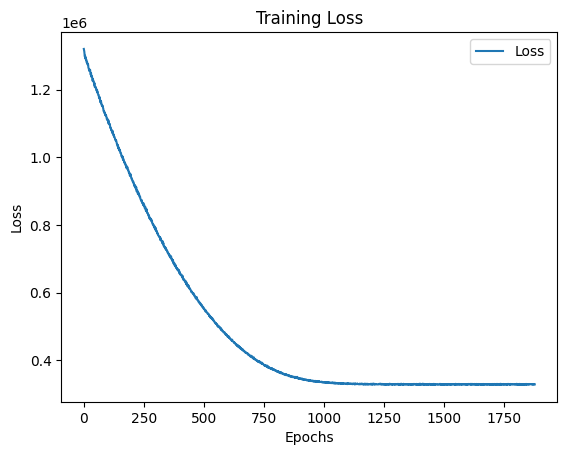

In [ ]:
import matplotlib.pyplot as plt
# Plot der Losskurve
plt.plot(range(len(losses)), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_residuals(y_true, y_pred, max_points=None):
    """
    Plots the residuals (y_pred - y_true) for each sample.
    If max_points is set, only the first max_points residuals are shown.
    Converts lists to numpy arrays for subtraction.
    """
    # Ensure numpy arrays
    y_true_arr = np.array(y_true, dtype=float)
    y_pred_arr = np.array(y_pred, dtype=float)
    residuals = y_pred_arr - y_true_arr

    if max_points is not None:
        residuals = residuals[:max_points]
    plt.figure()
    plt.scatter(range(len(residuals)), residuals)
    plt.xlabel('Sample Index')
    plt.ylabel('Residual (Prediction - Real)')
    plt.title('Residual Plot')
    plt.show()

def plot_pred_vs_real(y_true, y_pred, max_points=None):
    """
    Plots predicted vs. real values.
    If max_points is set, only the first max_points points are plotted.
    Converts lists to numpy arrays for plotting.
    """
    # Ensure numpy arrays
    y_true_arr = np.array(y_true, dtype=float)
    y_pred_arr = np.array(y_pred, dtype=float)

    if max_points is not None:
        y_true_arr = y_true_arr[:max_points]
        y_pred_arr = y_pred_arr[:max_points]
    plt.figure()
    plt.plot(y_true_arr, label='Real')
    plt.plot(y_pred_arr, label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Prediction vs. Real')
    plt.legend()
    plt.show()

# Usage example:
# y_true = [...]  # list of real values
# y_pred = [...]  # list of predicted values
# plot_residuals(y_true, y_pred)
# plot_pred_vs_real(y_true, y_pred)


y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy().ravel()
    y_true     = y_test.cpu().numpy().ravel()

print(min_max_denormalize(X_test)[0:10].tolist())
print(y_true[0:10])
print(y_pred[0:10])

[[[1722.0, 0.0005000000237487257]], [[4730.0, 0.0005000000237487257]], [[4503.0, 0.0005000000237487257]], [[493.0, 0.0005000000237487257]], [[6954.0, 0.0005000000237487257]], [[1725.0, 0.0005000000237487257]], [[1423.0, 0.0005000000237487257]], [[2633.0, 0.0005000000237487257]], [[8064.99951171875, 0.0005000000237487257]], [[1846.0, 0.0005000000237487257]]]
[ 946.   900.6   98.6 1390.8  345.   284.6  526.6 1613.   369.2  140. ]
[995.00055 995.00055 995.00055 995.00055 995.00055 995.00055 995.00055
 995.00055 995.00055 995.00055]


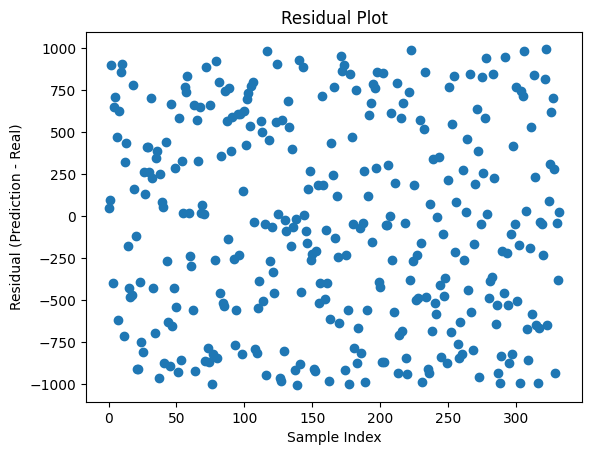

In [ ]:
plot_residuals(y_true, y_pred)

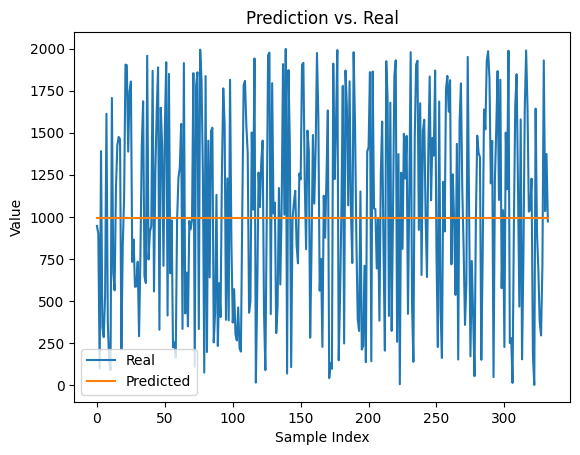

In [ ]:
plot_pred_vs_real(y_true, y_pred)

In [89]:
data_print = {
    'sigma_t': data[0][2+len(y_train):],
    'delta_epsilon': data[2][2+len(y_train):],
    'delta_sigma': data[1][2+len(y_train):],
    'delta_sigma_pred': y_pred.tolist(),
    'true - pred': [data[1][2+len(y_train):][i] - y_pred.tolist()[i] for i in range(len(y_true.tolist()))]
}

# Print a markdown table
display(pd.DataFrame(data_print).head(20))

,sigma_t,delta_epsilon,delta_sigma,delta_sigma_pred,true - pred
0,4730,0.0005,946.0,995.000549,-49.000549
1,4503,0.0005,900.6,995.000549,-94.400549
2,493,0.0005,98.6,995.000549,-896.400549
3,6954,0.0005,1390.8,995.000549,395.799451
4,1725,0.0005,345.0,995.000549,-650.000549
5,1423,0.0005,284.6,995.000549,-710.400549
6,2633,0.0005,526.6,995.000549,-468.400549
7,8065,0.0005,1613.0,995.000549,617.999451
8,1846,0.0005,369.2,995.000549,-625.800549
9,700,0.0005,140.0,995.000549,-855.000549


In [108]:
# prompt: Schreib mir eine Funktion in der ich eine Prognose von zwei Parametern machen kann. Berücksichtige Normalisierung und den benötigten Shape. Zusätzlich soll aus der Oedo Klasse der wahre Wert ermittelt werden und angezeigt werden. Schreib die Ergebnisse im Markdown Format auf.

def predict_oedometer(model, sigma_t_input, delta_epsilon_input, min_val, max_val, normalize=True):
    """
    Macht eine Prognose für delta_sigma basierend auf sigma_t und delta_epsilon
    unter Berücksichtigung von Normalisierung und der benötigten Tensor-Shape.

    Args:
        model (torch.nn.Module): Das trainierte LSTM-Modell.
        sigma_t_input (float): Der Eingabewert für sigma_t.
        delta_epsilon_input (float): Der Eingabewert für delta_epsilon.
        min_val (torch.Tensor): Das globale Minimum, das während des Trainings verwendet wurde.
        max_val (torch.Tensor): Das globale Maximum, das während des Trainings verwendet wurde.
        normalize (bool): Gibt an, ob der Input normalisiert werden soll.

    Returns:
        tuple: Ein Tuple mit (denormalisierte_prognose, wahrer_delta_sigma_wert),
               wobei der wahre Wert aus der Oedometer-Klasse ermittelt wird.
    """
    # Erstelle einen Tensor für die Eingabe
    # Die Form muss (batch_size, seq_length, input_size) sein.
    # Hier haben wir eine Batch-Größe von 1, eine Sequenzlänge von 1 (lookback=1)
    # und input_size von 2 (sigma_t, delta_epsilon).
    input_tensor = torch.tensor([[sigma_t_input, delta_epsilon_input]], dtype=torch.float32) # Shape (1, 1, 2)

    # Optional Normalisierung anwenden
    if normalize:
        # Hier müssen wir min_val und max_val so anpassen, dass sie für den 2D-Input Tensor passen
        # Die min_max_normalize Funktion wurde für den X_train Tensor (shape (batches, seq_len, features)) geschrieben
        # Wir müssen hier einen Tensor mit der gleichen Struktur erstellen, um die gleiche Normalisierung zu gewährleisten.
        # Da wir nur ein Sample haben (batch_size=1, seq_len=1), erstellen wir einen temporären Tensor:
        temp_tensor = torch.tensor([[sigma_t_input, delta_epsilon_input]], dtype=torch.float32).unsqueeze(0) # Shape (1, 1, 2)
        # Jetzt können wir die min_max_normalize Funktion verwenden, die intern min_val und max_val benutzt.
        normalized_input = min_max_normalize(temp_tensor)
        input_tensor = normalized_input.squeeze(0) # Shape wieder (1, 1, 2)
    else:
         # Auch wenn nicht normalisiert wird, stellen wir sicher, dass die Dimensionen korrekt sind
        input_tensor = input_tensor.unsqueeze(0) # Shape (1, 1, 2)


    # Setze das Modell in den Evaluierungsmodus
    model.eval()

    # Mache die Prognose ohne Gradientenberechnung
    with torch.no_grad():
        prediction = model(input_tensor)

    predicted_delta_sigma = prediction.item() # Konvertiere den Tensor zu einem Python-Float

    # Ermittle den wahren Wert aus der Oedometer-Klasse
    # Hier verwenden wir die Oedometer-Klasse, um den tatsächlichen delta_sigma Wert für die gegebenen Inputs zu berechnen
    oedo_para_prediction = {
        'max_n': 1, # Wir brauchen nur den ersten Schritt
        'e_0': 1.0,
        'C_c': 0.005,
        'sigma_t': sigma_t_input, # Der gegebene Input sigma_t
        'delta_epsilon': delta_epsilon_input, # Der gegebene Input delta_epsilon
        'total_epsilon': 0, # Wird für die delta_sigma Berechnung im ersten Schritt nicht benötigt
        'e_s': 400.0 # Wird für die delta_sigma Berechnung im ersten Schritt nicht benötigt
    }
    oedo_prediction = Oedometer(**oedo_para_prediction)
    # Der wahre delta_sigma Wert ist der erste Wert in der delta_sigma Liste der Oedometer-Instanz
    true_delta_sigma = oedo_prediction.delta_sigma[0]


    return predicted_delta_sigma, true_delta_sigma


example_sigma_t_input = 1
example_delta_epsilon_input = 0.0005

# Mache die Prognose
predicted_delta_sigma, true_delta_sigma = predict_oedometer(
    model,
    example_sigma_t_input,
    example_delta_epsilon_input,
    min_val, # Die globalen min/max für die Normalisierung des Inputs
    max_val, # Die globalen min/max für die Normalisierung des Inputs
    normalize=normalize # Stelle sicher, dass dies mit der Einstellung beim Training übereinstimmt
)

# Berechne die Differenz
difference = predicted_delta_sigma - true_delta_sigma

# Anzeige der Ergebnisse im Markdown-Format
display(Markdown("### Prognoseergebnis"))

display(Markdown(f"""
| Parameter             | Wert (Rohdaten) |
|-----------------------|-----------------|
| Eingabe sigma_t       | {example_sigma_t_input:.4f}   |
| Eingabe delta_epsilon | {example_delta_epsilon_input:.6f}   |
| Prognostizierte delta_sigma | {predicted_delta_sigma:.4f}   |
| Wahrer delta_sigma (Oedometer) | {true_delta_sigma:.4f}   |
| Differenz (Prognose - Wahr) | {difference:.4f}   |
"""))

### Skalierungseinheiten: Min. = 0.0005000000237487257, Max. = 9999.0

### Prognoseergebnis


| Parameter             | Wert (Rohdaten) |
|-----------------------|-----------------|
| Eingabe sigma_t       | 1.0000   |
| Eingabe delta_epsilon | 0.000500   |
| Prognostizierte delta_sigma | 995.0005   |
| Wahrer delta_sigma (Oedometer) | 0.2000   |
| Differenz (Prognose - Wahr) | 994.8005   |
